## 프로젝트 - Movielens 영화 추천 실습
MF 모델 학습 방법을 토대로, 내가 좋아할만한 영화 추천 시스템을 제작해 보겠습니다.
이번에 활용할 데이터셋은 추천시스템의 MNIST라고 부를만한 Movielens 데이터입니다.

- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
- 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해볼 수 있습니다.
- 별점을 시청횟수로 해석해서 생각하겠습니다.
- 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.

>1) wget으로 데이터 다운로드 >> $ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

>2) 다운받은 데이터를 작업디렉토리로 이동
>$ mv ml-1m.zip ~/aiffel/recommendata_iu/data

>3) gzip으로 압축된 압축을 해제하면 tar 파일이 하나 나옵니다. 
>$ unzip ml-1m.zip

---
## 1. 데이터 준비와 전처리
Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있다.

In [319]:
import os
import pandas as pd

rating_file_path = os.getenv('HOME') + '/Development/ML/Modu_Lab/recommendata_iu/ml_data/ratings.dat'
rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=rating_cols, engine='python')
original_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [320]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'original_data_size: {original_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / original_data_size:.2%}')

original_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [321]:
# rating 컬럼의 이름을 rate로 바꿉니다.
ratings.rename(columns={'rating':'rate'}, inplace=True)
ratings.head()

,user_id,movie_id,rate,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [322]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path = os.getenv('HOME') + '/Development/ML/Modu_Lab/recommendata_iu/ml_data/movies.dat'
cols = ['movie_id', 'title', 'genre']
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## 2. EDA
- ratings에 있는 유니크한 영화 개수
- rating에 있는 유니크한 사용자 수
- 가장 인기있는 영화 30개(인기순)

In [323]:
print(ratings.shape, movies.shape)    # 각 데이터 shape 확인
ratings['user_id'].nunique()     # unique한 id의 개수

(836478, 4) (3883, 3)


6039

In [324]:
# ratings와 movies를 합친다.
df = pd.merge(ratings, movies, on='movie_id')   # 'movie_id'를 기준으로 merge on 한다.
print(df.shape)
df.head()

(836478, 6)


,user_id,movie_id,rate,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


In [325]:
# 결측치 확인
# df.info()
df.isnull().sum()
df['title'].nunique()

3628

In [376]:
# 인기 많은 영화 (많은 유저가 본 영화들)
# movie_count = df['user_id'].groupby(df['title']).count()
movie_count = df.groupby('title')['user_id'].count()
movie_count.sort_values(ascending=False).head(20)

title
American Beauty (1999)                                   3212
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

In [327]:
# 유저별 관람 영화 통계 ???
user_count = df.groupby('user_id')['title'].count()
user_count.to_frame()

,title
user_id,
1,53
2,116
3,46
4,19
5,143
...,...
6036,708
6037,189
6038,18


In [328]:
# 영화별 평균 평점
df.groupby('title').mean().sort_values('rate', ascending=False).head()

,user_id,movie_id,rate,timestamp
title,,,,
Ulysses (Ulisse) (1954),3485.0,3172.0,5.0,967060437.0
Country Life (1994),1631.0,687.0,5.0,974725573.0
Schlafes Bruder (Brother of Sleep) (1995),1915.0,989.0,5.0,974693867.0
Foreign Student (1994),3618.0,572.0,5.0,967120177.0
Follow the Bitch (1998),2869.0,1830.0,5.0,972439040.0


In [329]:
# 영화별 user수 구하기
df['user_id'].groupby(df['title']).count()

title
$1,000,000 Duck (1971)                         26
'Night Mother (1986)                           56
'Til There Was You (1997)                      27
'burbs, The (1989)                            198
...And Justice for All (1979)                 185
                                             ... 
Zed & Two Noughts, A (1985)                    24
Zero Effect (1998)                            262
Zero Kelvin (Kj�rlighetens kj�tere) (1995)      2
Zeus and Roxanne (1997)                        12
eXistenZ (1999)                               306
Name: user_id, Length: 3628, dtype: int64

In [330]:
# user수가 1인 영화 리스트 ???

view_count = df.groupby('title')['user_id'].count().sort_values(ascending=False)
df.groupby('title')['user_id'].count().values == 1

array([False, False, False, ..., False, False, False])

---
## 3. Advanced EDA
1. user_id: 각 유저별 ID, 총 6,039명
2. movie_id: 각 영화별 ID, 총 3,628편
3. rate: 영화에 대한 별점, 5~3점 (2점 이하는 제거함)
4. timestamp: 시간정보
5. title: 각 영화 제목과 년도
6. genre: 각 영화의 장르

In [331]:
user_id_count = df['user_id'].nunique()
movie_id_count = df['movie_id'].nunique()
title_count = df['title'].nunique()
rate_count = df['rate'].value_counts()

print(f'user id count:{user_id_count} | movie id count:{movie_id_count} | title count:{title_count}')
print('rate type',rate_count, sep='\n')

user id count:6039 | movie id count:3628 | title count:3628
rate type
4    348971
3    261197
5    226310
Name: rate, dtype: int64


**인기있는 영화 순위 (평점 X 뷰수)**

In [332]:
# 인기있는 영화 순위 (평점 * 뷰수)
sum_rate = df['rate'].groupby(df['title']).sum().sort_values(ascending=False)
sum_view = df['user_id'].groupby(df['title']).sum().sort_values(ascending=False)
(sum_rate*sum_view).sort_values(ascending=False)[100:150]

title
Young Frankenstein (1974)                             17934377742
Edward Scissorhands (1990)                            17659350410
Rock, The (1996)                                      17645090430
High Fidelity (2000)                                  17524866942
American Pie (1999)                                   17412451760
Green Mile, The (1999)                                17375919288
Clueless (1995)                                       17265615780
Willy Wonka and the Chocolate Factory (1971)          17086180276
Erin Brockovich (2000)                                17073222502
Get Shorty (1995)                                     17013470960
Apocalypse Now (1979)                                 17012874156
Mission: Impossible (1996)                            16816114707
Sling Blade (1996)                                    16729229200
Fifth Element, The (1997)                             16553508032
Star Trek: First Contact (1996)                       16429990500
Cloc

**view count가 5회 이하인 영화들이 356편이나 있다.**   
Q. view수가 적어 학습에 도움이 될까요???

In [385]:
view_count = df.groupby('title').count()

view_count[view_count['user_id'] < 6]

,user_id,movie_id,rate,timestamp,genre
title,,,,,
1-900 (1994),1,1,1,1,1
24 7: Twenty Four Seven (1997),5,5,5,5,5
24-hour Woman (1998),1,1,1,1,1
3 Ninjas: High Noon On Mega Mountain (1998),3,3,3,3,3
3 Strikes (2000),3,3,3,3,3
...,...,...,...,...,...
"Wooden Man's Bride, The (Wu Kui) (1994)",1,1,1,1,1
Yankee Zulu (1994),2,2,2,2,2
Year of the Horse (1997),3,3,3,3,3


---
## 4. my_fav 영화 리스트 추가하기
- 'American Beauty (1999)'
- 'Pulp Fiction (1994)'
- 'High Fidelity (2000)'
- 'Seven (Se7en) (1995)'
- 'Cool Runnings (1993)'

In [334]:
my_fav = ['American Beauty (1999)','Pulp Fiction (1994)','High Fidelity (2000)','Seven (Se7en) (1995)','Cool Runnings (1993)']
my_fav_df = pd.DataFrame({'user_id': ['jaejun']*5, 'title': my_fav, 'rate': [5,5,4,5,4]}).merge(movies, how='left', on='title')

my_fav_df

,user_id,title,rate,movie_id,genre
0,jaejun,American Beauty (1999),5,2858,Comedy|Drama
1,jaejun,Pulp Fiction (1994),5,296,Crime|Drama
2,jaejun,High Fidelity (2000),4,3481,Comedy
3,jaejun,Seven (Se7en) (1995),5,47,Crime|Thriller
4,jaejun,Cool Runnings (1993),4,1020,Comedy


In [335]:
if not df.isin({'user_id':['jaejun']})['user_id'].any():
    df = df.append(my_fav_df)

df.tail(10)

,user_id,movie_id,rate,timestamp,title,genre
836473,5851,3607,5,9.577566e+08,One Little Indian (1973),Comedy|Drama|Western
836474,5854,3026,4,9.583469e+08,Slaughterhouse (1987),Horror
836475,5854,690,3,9.577443e+08,"Promise, The (Versprechen, Das) (1994)",Romance
836476,5938,2909,4,9.572734e+08,"Five Wives, Three Secretaries and Me (1998)",Documentary
836477,5948,1360,5,1.016564e+09,Identification of a Woman (Identificazione di ...,Drama
0,jaejun,2858,5,NaN,American Beauty (1999),Comedy|Drama
1,jaejun,296,5,NaN,Pulp Fiction (1994),Crime|Drama
2,jaejun,3481,4,NaN,High Fidelity (2000),Comedy
3,jaejun,47,5,NaN,Seven (Se7en) (1995),Crime|Thriller
4,jaejun,1020,4,NaN,Cool Runnings (1993),Comedy


**timestamp는 별 상관이 없으므로 삭제**

In [336]:
df_drop = df.drop(['timestamp'], axis=1)
df_drop.tail(10)

,user_id,movie_id,rate,title,genre
836473,5851,3607,5,One Little Indian (1973),Comedy|Drama|Western
836474,5854,3026,4,Slaughterhouse (1987),Horror
836475,5854,690,3,"Promise, The (Versprechen, Das) (1994)",Romance
836476,5938,2909,4,"Five Wives, Three Secretaries and Me (1998)",Documentary
836477,5948,1360,5,Identification of a Woman (Identificazione di ...,Drama
0,jaejun,2858,5,American Beauty (1999),Comedy|Drama
1,jaejun,296,5,Pulp Fiction (1994),Crime|Drama
2,jaejun,3481,4,High Fidelity (2000),Comedy
3,jaejun,47,5,Seven (Se7en) (1995),Crime|Thriller
4,jaejun,1020,4,Cool Runnings (1993),Comedy


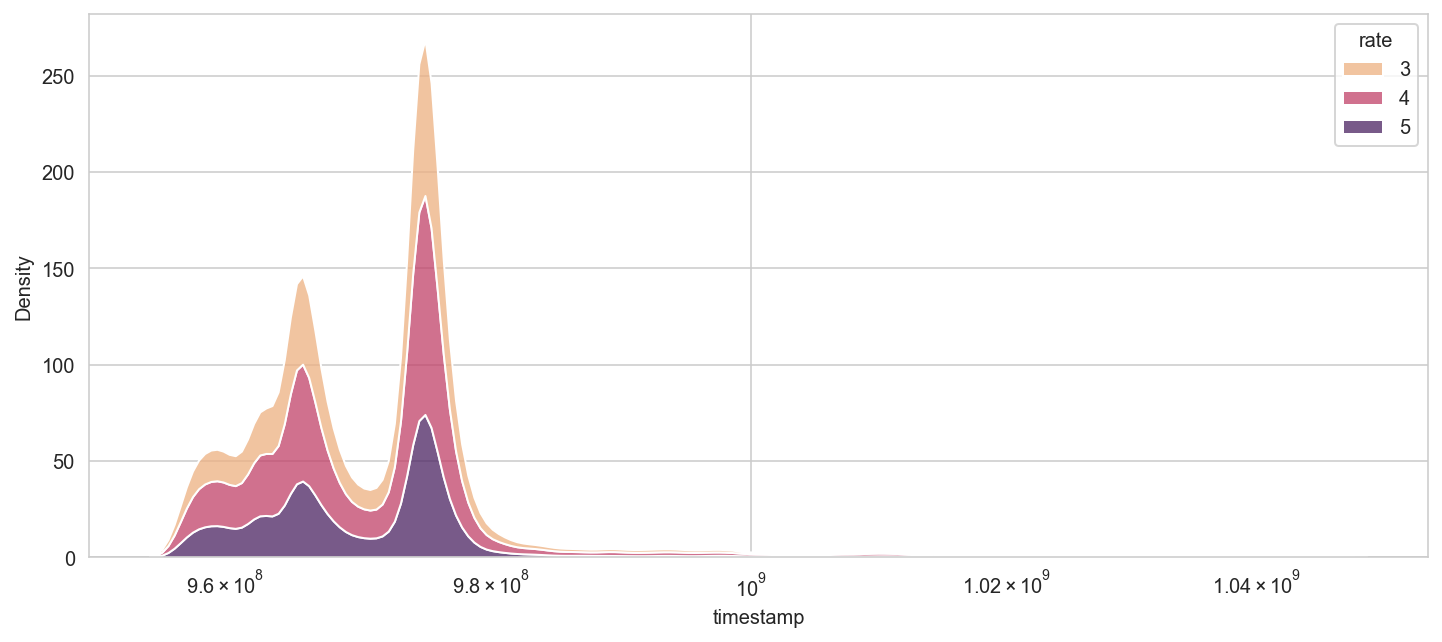

In [337]:
# timestamp와 rate의 관계 그래프
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 5))
sns.kdeplot(data=df, x='timestamp', hue='rate', log_scale=True, multiple='stack', palette='flare')
plt.show()

---
## 5.CSR Matrix

In [338]:
df.head()

,user_id,movie_id,rate,timestamp,title,genre
0,1,1193,5,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413.0,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179.0,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279.0,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471.0,One Flew Over the Cuckoo's Nest (1975),Drama


In [339]:
user_to_idx = {v:k for k,v in enumerate(df['user_id'].unique())}
movie_to_idx = {v:k for k,v in enumerate(df['movie_id'].unique())}
title_to_idx = {v:k for k,v in enumerate(df['title'].unique())}

In [340]:
user_to_idx['jaejun']

6039

In [341]:
def data_indexing():
    temp_user_data = df['user_id'].map(user_to_idx.get).dropna()
    if len(temp_user_data) == len(df):
        print('user_id column indexing OK!!')
        df['user_id'] = temp_user_data
    else:
        print('user_id column indexing Fail!!')

    temp_movie_data = df['movie_id'].map(movie_to_idx.get).dropna()
    if len(temp_movie_data) == len(df):
        print('movie column indexing OK!! \n')
        df['movie_id'] = temp_movie_data
    else:
        print('movie column indexing Fail!! \n')
        

In [342]:
display(df)

data_indexing()

display(df)

,user_id,movie_id,rate,timestamp,title,genre
0,1,1193,5,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413.0,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179.0,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279.0,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471.0,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
0,jaejun,2858,5,NaN,American Beauty (1999),Comedy|Drama
1,jaejun,296,5,NaN,Pulp Fiction (1994),Crime|Drama
2,jaejun,3481,4,NaN,High Fidelity (2000),Comedy
3,jaejun,47,5,NaN,Seven (Se7en) (1995),Crime|Thriller


user_id column indexing OK!!
movie column indexing OK!! 



,user_id,movie_id,rate,timestamp,title,genre
0,0,0,5,978300760.0,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,0,5,978298413.0,One Flew Over the Cuckoo's Nest (1975),Drama
2,2,0,4,978220179.0,One Flew Over the Cuckoo's Nest (1975),Drama
3,3,0,4,978199279.0,One Flew Over the Cuckoo's Nest (1975),Drama
4,4,0,5,978158471.0,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
0,6039,99,5,NaN,American Beauty (1999),Comedy|Drama
1,6039,222,5,NaN,Pulp Fiction (1994),Crime|Drama
2,6039,444,4,NaN,High Fidelity (2000),Comedy
3,6039,220,5,NaN,Seven (Se7en) (1995),Crime|Thriller


In [354]:
from scipy.sparse import csr_matrix

csr_data = csr_matrix((df.rate, (df.user_id, df.movie_id)), 
                      shape=(df['user_id'].nunique(), df['movie_id'].nunique()))
print(csr_data.shape)
print(csr_data)

(6040, 3628)
  (0, 0)	5
  (0, 1)	3
  (0, 2)	3
  (0, 3)	4
  (0, 4)	5
  (0, 5)	3
  (0, 6)	5
  (0, 7)	5
  (0, 8)	4
  (0, 9)	4
  (0, 10)	5
  (0, 11)	4
  (0, 12)	4
  (0, 13)	4
  (0, 14)	5
  (0, 15)	4
  (0, 16)	3
  (0, 17)	4
  (0, 18)	5
  (0, 19)	4
  (0, 20)	3
  (0, 21)	3
  (0, 22)	5
  (0, 23)	5
  (0, 24)	3
  :	:
  (6036, 1615)	5
  (6036, 1616)	5
  (6037, 726)	5
  (6037, 835)	4
  (6037, 913)	4
  (6037, 990)	5
  (6037, 997)	4
  (6037, 999)	5
  (6037, 1022)	5
  (6037, 1028)	5
  (6037, 1087)	5
  (6037, 1194)	4
  (6037, 1358)	3
  (6037, 1596)	5
  (6037, 1602)	5
  (6037, 1608)	5
  (6037, 1782)	3
  (6037, 2158)	3
  (6037, 3512)	3
  (6038, 2947)	3
  (6039, 99)	5
  (6039, 220)	5
  (6039, 222)	5
  (6039, 444)	4
  (6039, 605)	4


## 6. MF모델 학습

In [355]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [356]:
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)
csr_data_transpose = csr_data.T
csr_data_transpose


<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [357]:
als_model.fit(csr_data_transpose)

---
## 7. 예측하기(유사도와 추천 시스템)

In [365]:
# 훈련된 모델의 'Pulp Fiction'에 대한 나의 선호도

jaejun, pulp_fiction = user_to_idx['jaejun'], title_to_idx['Pulp Fiction (1994)']
jaejun_vector, pulp_fiction_vector = als_model.user_factors[jaejun], als_model.item_factors[pulp_fiction]


In [366]:
jaejun_vector

array([-6.3750762e-01,  1.5729572e-01,  1.5576057e-01, -6.4920402e-01,
        3.1274539e-01,  1.2658355e-01,  5.1774544e-01,  3.6915421e-01,
        1.9011134e-01, -3.2875481e-01,  2.2255130e-02,  2.5365468e-02,
        3.0746887e-02, -4.5040250e-01,  6.0563630e-01, -2.2376965e-01,
       -6.4906144e-01,  6.0734558e-01,  5.4459304e-01, -2.7854785e-01,
        4.5213568e-01, -3.8620564e-01,  7.1906561e-01,  4.0937206e-01,
       -2.8772622e-01, -3.9738664e-01, -8.7080896e-02, -4.4144619e-01,
       -3.1943813e-01, -3.3915791e-01, -2.4512449e-01, -2.5174552e-01,
        9.6641846e-02, -3.5482538e-01,  1.0886110e+00,  5.2272803e-01,
        9.4807988e-01,  5.4172838e-01,  6.3039768e-03,  1.1806062e-01,
        4.3778715e-01,  3.8623175e-01,  4.2932090e-01, -4.4635242e-01,
        6.3979045e-02, -7.2720297e-02,  3.6103335e-01,  6.6687125e-01,
       -3.0740502e-01, -4.3498728e-04,  1.9571461e-01, -1.1866184e-01,
        1.1065197e+00, -3.5893601e-01,  7.1721816e-01, -4.2659324e-01,
      

In [367]:
pulp_fiction_vector

array([-1.06083797e-02,  1.56023838e-02,  3.12704779e-02, -7.95278791e-03,
        2.29360666e-02, -1.22917565e-02,  1.45677954e-03,  1.67540554e-02,
        1.55338980e-02,  2.90414493e-04, -5.48677007e-03, -1.41052008e-02,
        2.81863268e-02, -1.51066491e-02,  2.59489380e-03, -1.49718393e-03,
        3.24621011e-04,  2.28444617e-02, -8.40611011e-03, -3.35086905e-03,
        2.84078475e-02, -4.97149862e-03,  1.47782033e-02,  7.51445582e-03,
       -1.09169887e-04,  2.06013955e-02, -2.70258100e-03,  1.86570932e-03,
        1.19802530e-03, -1.57802198e-02, -5.85816288e-03, -4.70313057e-03,
        1.33059975e-02, -6.74524531e-03,  4.14417610e-02, -6.68566581e-03,
        2.05130577e-02,  3.99162956e-02,  1.86784510e-02, -2.16004625e-02,
        1.22265527e-02,  2.78678793e-03,  3.47227901e-02,  1.54571636e-02,
        1.03686014e-02, -6.65899273e-03,  1.48977004e-02,  1.84527952e-02,
        5.38959866e-03, -1.40749873e-03,  1.49683449e-02,  1.96132660e-02,
        4.45742868e-02, -

In [368]:
# jaejun과  pulp fiction을 내적하는 코드
np.dot(jaejun_vector, pulp_fiction_vector)

0.5256353

**7-1. pred_score() 함수를 만들어 보자.**

In [375]:
def pred_score(user, title):
    user_vector, title_vector = als_model.user_factors[user_to_idx[user]], als_model.item_factors[title_to_idx[title]] 
    return np.dot(user_vector, title_vector)

pred_score('jaejun', 'Cool Runnings (1993)')

# 'American Beauty (1999)'    # 0.6310682
# 'Pulp Fiction (1994)'     # 0.5256353
# 'High Fidelity (2000)'    # 0.48079643
# 'Seven (Se7en) (1995)'    # 0.369011
# 'Cool Runnings (1993)'    # 0.09149716

0.09149716

In [377]:
pred_score('jaejun', 'Back to the Future (1985)')

-0.0151108345

In [387]:
pred_score('jaejun', 'Toy Story (1995)')

-0.03026654

In [386]:
pred_score('jaejun', 'Rear Window (1954)')

0.07707428

**7-2. 선호하는 영화와 비슷한 영화 찾기**

In [389]:
favorite_movie = title_to_idx['Pulp Fiction (1994)']
similar_movie = als_model.similar_items(favorite_movie, N=15)
similar_movie

[(222, 1.0000002),
 (269, 0.86316997),
 (51, 0.80980706),
 (157, 0.74826723),
 (233, 0.74080235),
 (289, 0.67347294),
 (121, 0.6477973),
 (248, 0.5462768),
 (220, 0.51511365),
 (23, 0.49454662),
 (224, 0.49356827),
 (278, 0.4871033),
 (3601, 0.4562607),
 (59, 0.43256405),
 (472, 0.40605137)]

In [390]:
idx_to_title = {v:k for k,v in title_to_idx.items()}
[idx_to_title[i[0]] for i in similar_movie]

['Pulp Fiction (1994)',
 'GoodFellas (1990)',
 'Fargo (1996)',
 'Shawshank Redemption, The (1994)',
 'Usual Suspects, The (1995)',
 'Reservoir Dogs (1992)',
 'Silence of the Lambs, The (1991)',
 'Good Will Hunting (1997)',
 'Seven (Se7en) (1995)',
 "Schindler's List (1993)",
 'L.A. Confidential (1997)',
 'Jackie Brown (1997)',
 'Condition Red (1995)',
 'Few Good Men, A (1992)',
 'Sling Blade (1996)']

In [398]:
# 비슷한 영화 찾기 함수 만들기
idx_to_title = {v:k for k,v in title_to_idx.items()}

def find_similar_movie(title, N=10):
    # 항상 첫번째 추천 영화는 입력한 영화와 같으므로 drop해준다.
    similar_movie = als_model.similar_items(title_to_idx[title], N=N+1) 
    similar_movie = [(idx_to_title[i[0]],i[1]) for i in similar_movie]
    return pd.DataFrame(similar_movie[1:], index=range(1,N+1), columns=['title', 'similarity']).merge(movies, how='left', on='title').drop(columns=['movie_id'])

In [399]:
find_similar_movie('Seven (Se7en) (1995)')

,title,similarity,genre
0,Reservoir Dogs (1992),0.795948,Crime|Thriller
1,"Usual Suspects, The (1995)",0.697006,Crime|Thriller
2,"Simple Plan, A (1998)",0.636765,Crime|Thriller
3,Pulp Fiction (1994),0.515114,Crime|Drama
4,Jackie Brown (1997),0.502362,Crime|Drama
5,Heat (1995),0.501912,Action|Crime|Thriller
6,Kiss the Girls (1997),0.487928,Crime|Drama|Thriller
7,"Lock, Stock & Two Smoking Barrels (1998)",0.481184,Comedy|Crime|Thriller
8,Casino (1995),0.466745,Drama|Thriller
9,"Professional, The (a.k.a. Leon: The Profession...",0.464181,Crime|Drama|Romance|Thriller
